<h1> Evaluating different chunking strategies, chunk sizing and overlap using RAGA framework: Claude 3 Sonnet on Bedrock for LLM, FAISS for Vector Store and RAGA for Evaluation   <h1>

#### Identifying  documents best chunking Strategy is key to increase the accuracy of retrieved responses with solutions involving RAG and LLM models. The following notebooks implements a framework to evaluate different chuncking strategies. The goal is not to identify the best chunking strategy in the context of the example from the notebook rather to provide a tool to implement this evaluation for real case example 
The notebook follow the following steps
1. Install required libraries
2. Create a bedrock Client
3. Load documents example in a local folder
4. Use a custom function "textsplitterStrategy" with 3 params : Strategy , chunk size and overlap
5. run the function for 5 chunking strategies and load the documents in FAISS (5 stores)
6. Use Claude3 Sonnet and RAGA to evaluate  context_recall,context_precision,  answer_relevancy
7. plot the evaluation results

    

<h4>Install required libraries<h4>

In [ ]:
!pip3 install -U boto3==1.34.143 --force-reinstall --quiet 
#%pip install langchain --force-reinstall 
!pip3 install pypdf==3.8.1 faiss-cpu==1.7.4 --force-reinstall --quiet
!pip3 install -U  langchain --quiet
!pip3 install spacy --quiet
!pip3 install -U datasets --quiet
!pip3 install --upgrade google-cloud-aiplatform --quiet
!pip3 install fsspec --quiet 
!pip3 install -U ragas --quiet
!pip3 install pydantic==1.10.14 --force-reinstall  --quiet
!python3 -m spacy download en_core_web_sm --quiet
!pip3 install en_core_web_sm --quiet
!pip3 install spacy --quiet
!pip3 install -U langfuse --quiet


In [7]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

<h4>Create a bedrock client using boto3<h4>

In [8]:
# 2.Create a bedrock Client
import json
import os
import boto3
import pprint
import random
from retrying import retry
boto3_session = boto3.session.Session()
region_name = boto3_session.region_name
bedrock_agent_client = boto3_session.client('bedrock-agent', region_name=region_name)
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=region_name,
)

pp = pprint.PrettyPrinter(indent=2)


<h2>Load documents example in a local folder</h2>

In [9]:
# uncomment this line if folder not created yet 
#!mkdir -p ./data

from urllib.request import urlretrieve
urls = [
    'https://s2.q4cdn.com/299287126/files/doc_financials/2023/ar/2022-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/2021-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2021/ar/Amazon-2020-Shareholder-Letter-and-1997-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2020/ar/2019-Shareholder-Letter.pdf'
]

filenames = [
    'AMZN-2022-Shareholder-Letter.pdf',
    'AMZN-2021-Shareholder-Letter.pdf',
    'AMZN-2020-Shareholder-Letter.pdf',
    'AMZN-2019-Shareholder-Letter.pdf'
]

metadata = [
    dict(year=2022, source=filenames[0]),
    dict(year=2021, source=filenames[1]),
    dict(year=2020, source=filenames[2]),
    dict(year=2019, source=filenames[3])]

data_root = "./data/"

for idx, url in enumerate(urls):
    file_path = data_root + filenames[idx]
    urlretrieve(url, file_path)

<h3> Use a custom function "textsplitterStrategy" with 3 params : Strategy , chunk size and overlap</h3>

In [10]:
# 4. Use a custom function "textsplitterStrategy" with 3 params : Strategy , chunk size and overlap
#textsplitter function : 
# param 1 : strategy   (LatexTextSplitter== 2 ), (NLTKTextSplitter== 1) ,(MarkdownTextSplitter' == 3)  , (RecursiveCharacterTextSplitter == 4),  strategytext='SpacyTextSplitter'
#param 2: chunksize 
#param 3: overlapp

#reminder of each Strategy 

 # Markdown: Markdown is a lightweight markup language commonly used for formatting text. By recognizing the Markdown syntax (e.g., headings, lists, and code blocks), 
 # Recursive chunking divides the input text into smaller chunks in a hierarchical and iterative manner using a set of separators.
 #LaTex: LaTeX is a document preparation system and markup language often used for academic papers and technical documents. chunks respects the logical organization of the content (e.g., sections, subsections, and equations
 # NLTK is a free, open-source library for advanced Natural Language Processing (NLP) in Python. It can help simplify textual data and gain in-depth information from input messages.
# Spacy, another powerful NLP library, provides a sentence tokenization function that relies heavily on linguistic rules. It is a similar approach to NLTK.

def textsplitterStrategy(strategy, chunksize , overlap):
    from langchain.text_splitter import LatexTextSplitter
    from langchain.text_splitter import MarkdownTextSplitter
    from langchain.text_splitter import SpacyTextSplitter
    from langchain.text_splitter import NLTKTextSplitter
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from langchain_experimental.text_splitter import SemanticChunker
    from langchain_openai.embeddings import OpenAIEmbeddings
    import nltk
    import numpy as np
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from langchain.document_loaders import PyPDFLoader
    documents = []
    docs =[]

    for idx, file in enumerate(filenames):
        loader = PyPDFLoader(data_root + file)
        document = loader.load()
        for document_fragment in document:
            document_fragment.metadata = metadata[idx]
        
        documents += document

    if (strategy == 2):
        text_splitter = LatexTextSplitter(
            chunk_size =  chunksize,
            chunk_overlap  = overlap,
        )
        docs = text_splitter.split_documents(documents)
  
    if (strategy == 1):
        text_splitter = NLTKTextSplitter(
            chunk_size =  chunksize,
            chunk_overlap  = overlap,
         
        )
        docs = text_splitter.split_documents(documents) 
    if (strategy == 3):
        text_splitter = MarkdownTextSplitter(
            chunk_size =  chunksize,
            chunk_overlap  = overlap,
        )
        docs = text_splitter.split_documents(documents)
    if (strategy == 4):
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size =  chunksize,
            chunk_overlap  = overlap,
           # is_separator_regex=False,
            separators=["\n\n", "\n", ' ', ''],
            length_function = len
            
        )
        docs = text_splitter.split_documents(documents)  
    if (strategy == 5):
        text_splitter = SpacyTextSplitter(
            chunk_size =  chunksize,
            chunk_overlap  = overlap
           #separator = ['\n', '=', ',', '&']
        )
        docs = text_splitter.split_documents(documents) 
    avg_doc_length = lambda documents: sum([len(doc.page_content) for doc in documents])//len(documents)
    print(f'Average length among {len(documents)} documents loaded is {avg_doc_length(documents)} characters.')
    print(f'After the split we have {len(docs)} documents as opposed to the original {len(documents)}.')
    print(f'Average length among {len(docs)} documents (after split) is {avg_doc_length(docs)} characters.')         
    return docs 

In [11]:
#get stragtey label to dispaly when plotting
def Strategy_label(strategy):
    strategytext=""
    if (strategy == 2):
        strategytext='LatexTextSplitter'
    if (strategy == 1):
       strategytext='NLTKTextSplitter'
    if (strategy == 3):
          strategytext='MarkdownTextSplitter'
    if (strategy == 4):
        strategytext='RecursiveCharacterTextSplitter'
    if (strategy == 5):
        strategytext='SpacyTextSplitter'
    return strategytext 

### Provide as parameter one of strategies below : and load chunk in a list of chunked documents
#### 1 : NLTKTextSplitter
#### 2 :LatexTextSplitter
#### 3:MarkdownTextSplitter
#### 4:RecursiveCharacterTextSplitter
#### 5:SpacyTextSplitter
### Provide chunk size and overlap for docs with different strategies

In [12]:
#  Provide parameter one of those strategies: and load chunk in a list fo chunked documents
#1: NLTKTextSplitter
#2: LatexTextSplitter
#3: MarkdownTextSplitter
#4: RecursiveCharacterTextSplitter
#5: SpacyTextSplitter
#vectors for docs with different strategies
#  chunk size as paramter : 1000 here for example purpose
#  pass overlap as paramter : 50 here for example purpose  
!pip install --quiet langchain_experimental langchain_openai
my_docs = []
my_strategies =[]
strategy=""
strategytext=""
for x in [1,2,3,4,5]:
    strategy=Strategy_label(x)  
    print (strategy)
    prefixed_name = "docs_" + str(x)
    prefixed_name =  textsplitterStrategy(x,1000,150)
    my_docs.append(prefixed_name)
    my_strategies.append(strategy)

NLTKTextSplitter
Average length among 37 documents loaded is 3889 characters.
After the split we have 184 documents as opposed to the original 37.
Average length among 184 documents (after split) is 843 characters.
LatexTextSplitter
Average length among 37 documents loaded is 3889 characters.
After the split we have 203 documents as opposed to the original 37.
Average length among 203 documents (after split) is 794 characters.
MarkdownTextSplitter
Average length among 37 documents loaded is 3889 characters.
After the split we have 209 documents as opposed to the original 37.
Average length among 209 documents (after split) is 745 characters.
RecursiveCharacterTextSplitter
Average length among 37 documents loaded is 3889 characters.
After the split we have 209 documents as opposed to the original 37.
Average length among 209 documents (after split) is 745 characters.
SpacyTextSplitter


/opt/conda/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Average length among 37 documents loaded is 3889 characters.
After the split we have 182 documents as opposed to the original 37.
Average length among 182 documents (after split) is 852 characters.


### Bedrock embedding model : amazon.titan-embed-text-v1

In [14]:
from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock
!pip install --quiet langchain_experimental langchain_openai
bedrock_client = boto3.client(service_name='bedrock-runtime', 
                              region_name='us-east-1')
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1",
                                       client=bedrock_client)

#### Run the function for 5 chunking strategies and load the documents in FAISS (5 stores)
#### the execution of this loop  would requires 2-3 minutes to embed chunks and load them as vector in FAISS
#### 5 strategies , 5 chunked documents (same documents chunked using different strategies) and loaded to FAISS: One store per Strategy¶


In [15]:
from langchain.vectorstores import FAISS #from langchain.indexes import VectorstoreIndexCreator
db_vector =[]
for x in [1,2,3,4,5]:
    db  = FAISS.from_documents(
        my_docs[x-1],
        bedrock_embeddings,
    )
    db_vector.append(db)
#print(db_vector[1].index.ntotal)

#### Test the Vector Stores : use db_vector[x] , where x = 0,1,2,3,4
##### 1: NLTKTextSplitter
##### 2: LatexTextSplitter
##### 3: MarkdownTextSplitter
##### 4: RecursiveCharacterTextSplitter
##### 5: SpacyTextSplitter

In [ ]:
#test on the list of DBs
query = "What is Amazon doing in the field of Generative AI?"
retriever = db_vector[1].as_retriever()
retrievalResults  = retriever.invoke(query)
print(retrievalResults)

#### Define LLM prompt

In [28]:
contexts = []
#LLM prompt
prompt = f"""
Human: You are an advisor AI system, and provides answers to questions. 
Use the following pieces of information to provide a concise answer to the question enclosed in <question> tags. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
<context>
{contexts}
</context>

<question>
{query}
</question>

The response should be specific.

Assistant:"""

#### Define LLM paramters including max_tokens size, temperature and top-p

In [29]:

# payload with model paramters
messages=[{ "role":'user', "content":[{'type':'text','text': prompt.format(contexts, query)}]}]
sonnet_payload = json.dumps({
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 3000,
    "messages": messages,
    "temperature": 0.5,
    "top_p": 1    }  )

#### install boto3 required version , uncomment if errors only 

In [30]:
#%pip install -U boto3==1.34.52 --force-reinstall --quiet ##==1.33.2 

#### Define LLM used for test : on our case model used for test anthropic.claude-3-sonnet-20240229-v1:0 on Bedrock 

In [31]:
from langchain.llms.bedrock import Bedrock
from langchain_community.chat_models.bedrock import BedrockChat
from langfuse.decorators import observe, langfuse_context

modelId = 'anthropic.claude-3-sonnet-20240229-v1:0' # change this to use a different version from the model provider
accept = 'application/json'
contentType = 'application/json'
response = bedrock_client.invoke_model(body=sonnet_payload, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())
response_text = response_body.get('content')[0]['text']
llm = BedrockChat(model_id=modelId, 
                  client=bedrock_client)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `BedrockChat` was deprecated in LangChain 0.0.34 and will be removed in 0.3. An updated version of the class exists in the langchain-aws package and should be used instead. To use it run `pip install -U langchain-aws` and import as `from langchain_aws import ChatBedrock`.
  warn_deprecated(


#### Define RAG Chain evaluator 

In [32]:
#define RAG Chain evaluator 

from langchain.prompts import ChatPromptTemplate ,PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

PROMPT_TEMPLATE = """
    Human: You are an advisor AI system, and provides answers to questions by using fact based and statistical information when possible. 
    Use the following pieces of information to provide a concise answer to the question enclosed in <question> tags. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    <context>
    {context}
    </context>

    <question>
    {question}
    </question>

    The response should be specific and use statistics or numbers when possible.

    Assistant:"""

prompt = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt2 = PromptTemplate.from_template(PROMPT_TEMPLATE)

# Setup RAG pipeline
rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()} 
    | prompt 
    | llm
    | StrOutputParser() 
)

### Define RAGAS metrics LLM  : Context_recall, context_precision, answer_relevancy

##### Context_recall : Context recall measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. It is computed based on the ground truth and the retrieved context, and the values range between 0 and 1, with higher values indicating better performance.

##### Context Precision is a metric that evaluates whether all of the ground-truth relevant items present in the contexts are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks.

##### Answer Correctness¶ : The assessment of Answer Correctness involves gauging the accuracy of the generated answer when compared to the ground truth. This evaluation relies on the ground truth and the answer, with scores ranging from 0 to 1. A higher score indicates a closer alignment between the generated answer and the ground truth, signifying better correctness.

###### https://docs.ragas.io/en/latest/concepts/metrics/index.html

In [33]:
from ragas.metrics import (
    context_precision,
    faithfulness,
    context_recall,
    answer_relevancy

)
from ragas.metrics.critique import harmfulness

# list of metrics we're going to use
metrics = [
   # faithfulness,
    context_recall,
    context_precision,
  #  harmfulness,
    answer_relevancy
    
]

#### Integrates with langfuse, using your own API keys 
#### you should have created a languefuse accounts and create API key and secrets as pre-requisite 

In [34]:
from langfuse import Langfuse
#langfuse_handler.flush()

langfuse = Langfuse(
  secret_key="XXXXX", # provide own secret here
  public_key="XXXXX", # provide own key here
  host="https://cloud.langfuse.com"
)

#### This function will be called by Store in order to evaluate RAGA metrics
#### This function ensure that you will use the right retriever to relevant to store i e strategy
#### It also sends traces to langefuse for tracability for latency calculation 
#### Questions and Ground_truths are used from other AWS github examples 

In [35]:
def evaluatewithRerieverLangfusion (retriever_name,i):
    questions = ["How many days has Amazon asked employees to come to work in office?", 
                 "By what percentage did AWS revenue grow year-over-year in 2022?",
                 "Compared to Graviton2 processors, what performance improvement did Graviton3 chips deliver according to the passage?",
                 "Which was the first inference chip launched by AWS according to the passage?",
                 "According to the context, in what year did Amazon's annual revenue increase from $245B to $434B?",
                 "What did the president say about Intel's CEO?",
                ]
    ground_truths = [["Amazon has asked corporate employees to come back to office at least three days a week beginning May 2022."],
                    ["AWS had a 29% year-over-year ('YoY') revenue in 2022 on $62B revenue base."],
                    ["In 2022, AWS delivered their Graviton3 chips, providing 25% better performance than the Graviton2 processors."],
                    ["AWS launched their first inference chips (“Inferentia”) in 2019, and they have saved companies like Amazon over a hundred million dollars in capital expense."],
                    ["Amazon's annual revenue increased from $245B in 2019 to $434B in 2022."],
                    ["The president asked Congress to pass proven measures to reduce gun violence."]]
    
    answers = []
    contexts = []
    ragas_scores = []
    #print ("retriever_name" ,retriever_name)
    # Inference
    for query in questions:
      answers.append(rag_chain.invoke(query))
      trace = langfuse.trace(name=my_strategies[i], user_id="user1234", tags=["development"])
      contexts.append([docs.page_content for docs in retriever_name.get_relevant_documents(query)])
      #print (contexts)
      trace.span(name="retrieval", 
                   input={"question": questions}, 
                   output={"contexts": contexts},
            )

    answer = rag_chain.invoke(query)
   

    trace.span(
                name="generation",
                input={"question": questions, "contexts": contexts},
                output={"answer": answer}
            )


    data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truths": ground_truths
    }
    # Convert dict to dataset
    dataset = Dataset.from_dict(data)
    return dataset

#### Use Claude3 sonnet,  RAGA to evaluate context_recall,context_precision, answer_relevancy, load traces into Langfuse
#### Load all results in dataframes in order to plot results 
#### Execution time will take between 5 - 10 minutes

In [ ]:
# RAGA tested on the 5 FAISS strors  
from datasets import Dataset
from ragas import evaluate
import nest_asyncio  # CHECK NOTES
df_vector= []
# NOTES: Only used when running on a jupyter notebook, otherwise comment or remove this function.
nest_asyncio.apply()

for i in [0,1,2,3,4]:
    retriever = db_vector[i].as_retriever()
    #print (retriever)
    dataset=  evaluatewithRerieverLangfusion(retriever,i)
    for x in [1,2,3,4,5]:
        result = evaluate(
            dataset.select(range(x)),
            metrics=metrics,
            llm=llm,
            embeddings=bedrock_embeddings,
        )
        # print(result)
        df = result.to_pandas()
       
    df_vector.append(df)

In [ ]:
#### Test dataframes results : use df_vector[x] , where x = 0,1,2,3,4
##### 1: NLTKTextSplitter
##### 2: LatexTextSplitter
##### 3: MarkdownTextSplitter
##### 4: RecursiveCharacterTextSplitter
##### 5: SpacyTextSplitter

In [ ]:
df_vector[3]

#### Plot results per strategy

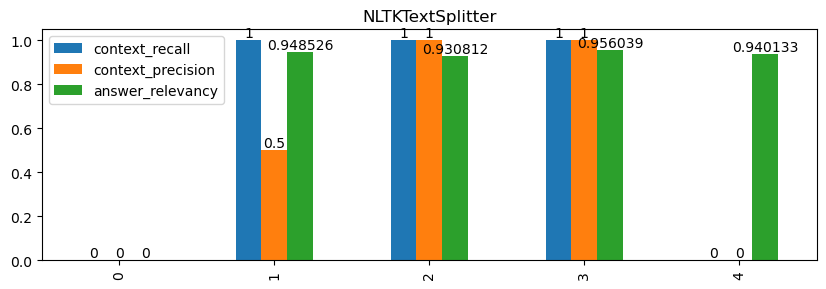

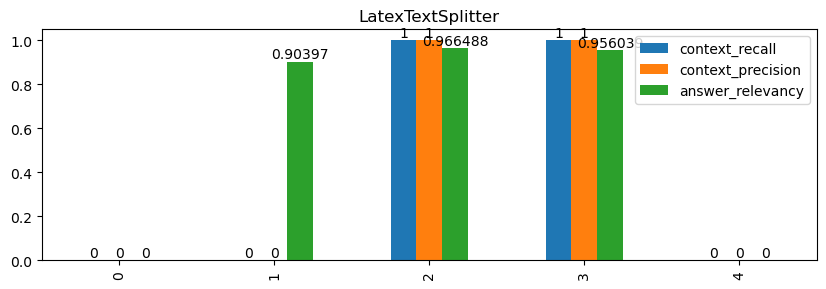

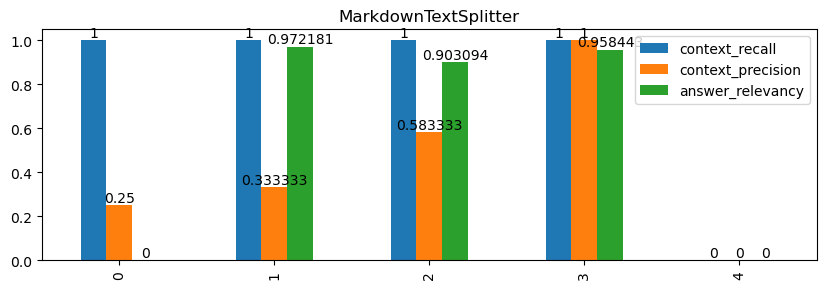

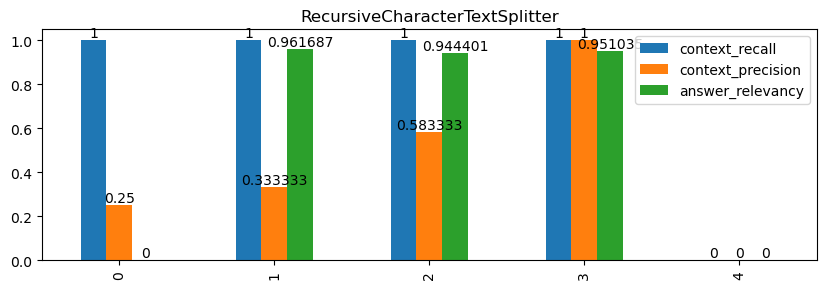

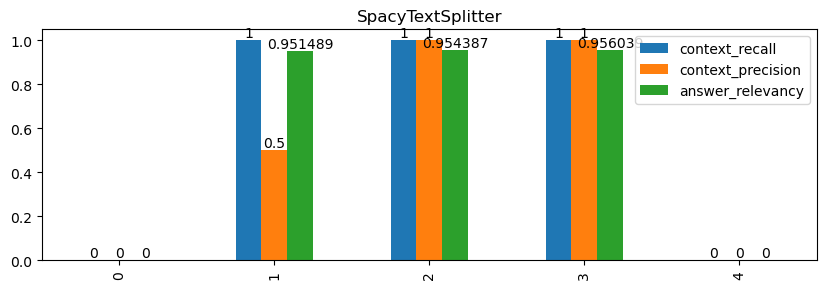

In [38]:

for i in [0,1,2,3,4]:
    ax = df_vector[i].plot.bar(figsize=(10,3) , title=my_strategies[i])
    for container in ax.containers:
        ax.bar_label(container)



### Plot Results as aggregated Score in one Dashboard

                         strategy  context_recall  context_precision  \
1                NLTKTextSplitter             0.6           0.500000   
2               LatexTextSplitter             0.4           0.400000   
3            MarkdownTextSplitter             0.8           0.433333   
4  RecursiveCharacterTextSplitter             0.8           0.433333   
5               SpacyTextSplitter             0.6           0.500000   

   answer_relevancy  
1          0.755102  
2          0.565299  
3          0.566744  
4          0.571425  
5          0.572383  


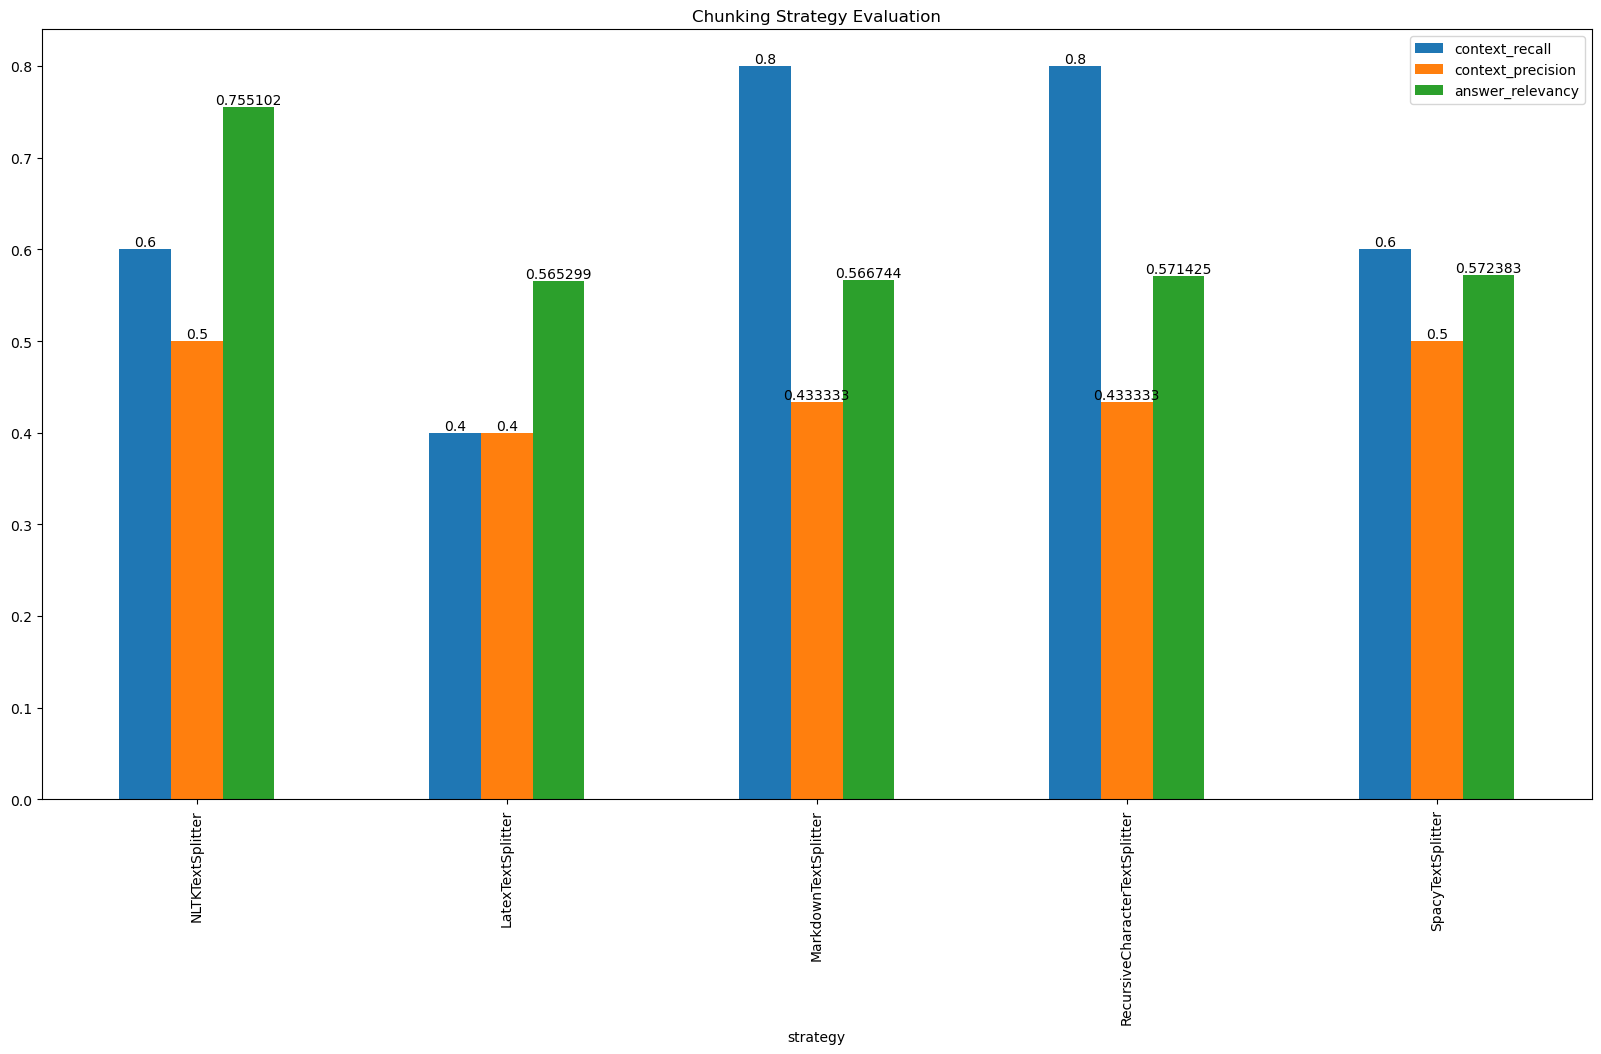

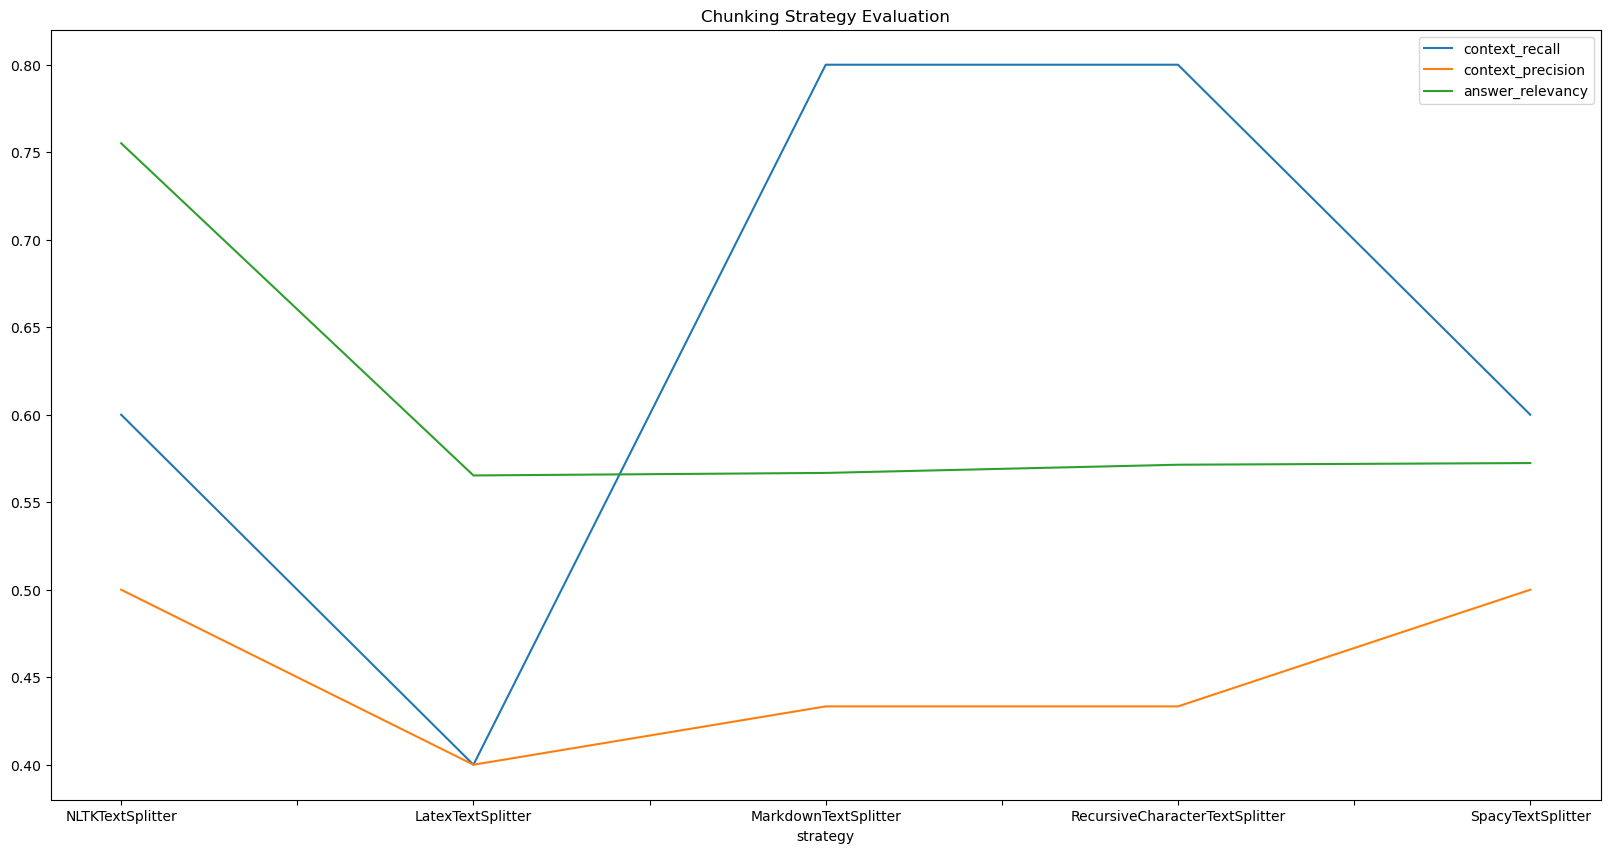

In [39]:
## create average DF Per strategy 
import pandas as pd
import matplotlib.pyplot as plt
dict = {'strategy' :[0], 'context_recall':[0],'context_precision':[0] , 'answer_relevancy':[0] }
averagedf=pd.DataFrame(dict)
#averagedf= pd.DataFrame(columns = ['Strategy', 'context_recall','context_precision' , 'answer_relevancy' ])
for i in [0,1,2,3,4]:
   df2 = {'strategy': my_strategies [i],'context_recall': df_vector[i]["context_recall"].mean() ,  'context_precision': df_vector[i]["context_precision"].mean()
          , 'answer_relevancy': df_vector[i]["answer_relevancy"].mean() }
   averagedf = averagedf._append(df2, ignore_index = True)
   
averagedf  = averagedf.drop(averagedf [(averagedf.strategy == '0')].index)
averagedf = averagedf.drop([0])
print (averagedf)

ax = averagedf.plot.bar(x='strategy' ,figsize=(20,10) , title= "Chunking Strategy Evaluation") 
for container in ax.containers:
        ax.bar_label(container)
plt.show()
ax2 = averagedf.plot('strategy' ,figsize=(20,10) , title= "Chunking Strategy Evaluation") 
for container in ax2.containers:
        ax2.bar_label(container)
plt.show()